# Neural Network
<a href="https://colab.research.google.com/github/cc-ats/mlp_class/blob/main/mueller_brown.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For the definition of Mueller-Brown potential, see https://www.wolframcloud.com/objects/demonstrations/TrajectoriesOnTheMullerBrownPotentialEnergySurface-source.nb.

$v(x,y) = \sum_{k=0}^3 A_k \mathrm{exp}\left[ a_k (x - x_k^0)^2 + b_k (x - x_k^0) (y - y_k^0) + c_k (y - y_k^0)^2 \right] $

**Generate Traning Data**

In [ ]:
from math import exp, pow, tanh
import numpy as np
import matplotlib.pyplot as plt


def mueller_brown_potential(x, y):
    A = [-200, -100, -170, 15]
    a = [-1, -1, -6.5, 0.7]
    b = [0, 0, 11, 0.6]
    c = [-10, -10, -6.5, 0.7]
    x0 = [1, 0, -0.5, -1.0]
    y0 = [0, 0.5, 1.5, 1]
    value = 0
    for k in range(0, 4):
        value += (
            0.1
            * A[k]
            * exp(
                a[k] * pow(x - x0[k], 2.0)
                + b[k] * (x - x0[k]) * (y - y0[k])
                + c[k] * pow(y - y0[k], 2.0)
            )
        )
    return value


# main function
xx = np.arange(-1.8, 1.4, 0.1)
yy = np.arange(-0.4, 2.4, 0.1)
X, Y = np.meshgrid(xx, yy)
xy, xy_truncated = [], []
z, z_truncated = [], []
for y in yy:
    for x in xx:
        v = mueller_brown_potential(x, y)
        z.append(v)
        xy.append([x, y])
        if v < 10:  # keep only low-energy points for ML training
            xy_truncated.append([x, y])
            z_truncated.append(v)
Z = np.reshape(z, (len(yy), -1))
print("Zmin:", np.amin(Z), "Zmax:", np.amax(Z))
print("Size of (future) training set:", len(z_truncated))

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y,cmin=-20, cmax=35)])
fig.update_traces(contours_z=dict(show=True, project_z=True))
fig.update_layout(title='Mueller-Brown Potential', width=500, height=500,
                  scene = dict(
                      zaxis = dict(nticks=12, range=[-20, 35]),
                      camera_eye = dict(x=-1.2, y=-1.2, z=1.2)))
fig.show()

**3-d Projection Surface**

**Contour surface**

In [ ]:
fig = plt.figure(figsize=(6, 5), dpi=100)
levels = [-12, -10, -8, -6, -4, -2, 0, 4, 8]
ct = plt.contour(X, Y, Z, levels, colors="k")
plt.clabel(ct, inline=True, fmt="%3.0f", fontsize=8)
ct = plt.contourf(X, Y, Z, levels, cmap=plt.cm.rainbow, extend="both", vmin=-15, vmax=0)
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.show()

**Loading PyTorch and training data**

In [ ]:
!pip install pytorch-lightning > /dev/null

import math
from typing import Sequence, Tuple
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

dataset = TensorDataset(Tensor(xy_truncated), Tensor(z_truncated))
train_loader = DataLoader(dataset, batch_size=32)
print("Size of training set:", len(train_loader.dataset))

**A Basic Neural Network**

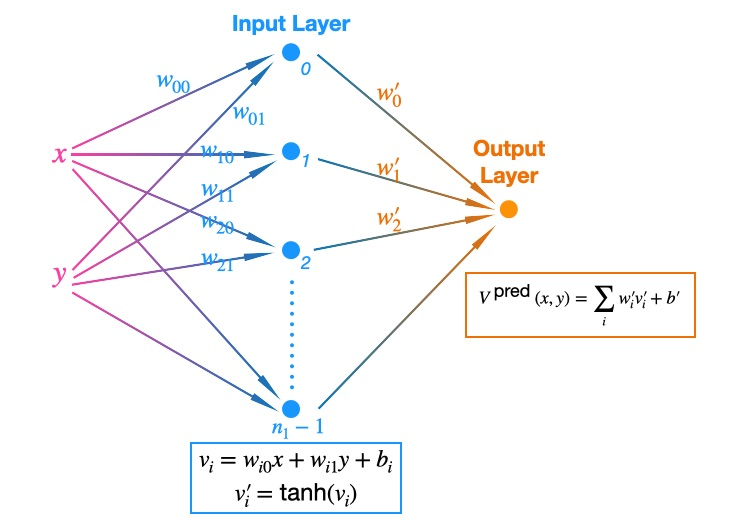

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, n1=20):  # n1 is the number of neurons for the first layer
        super().__init__()
        self.model = nn.Sequential(nn.Linear(2, n1), nn.Tanh(), nn.Linear(n1, 1))

    def forward(self, x):
        return self.model(x)


def train_loop(dataloader, model, optimizer, i_epoch):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = F.mse_loss(pred.squeeze(), y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 15 == 0 and i_epoch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(
                f"epoch: {i_epoch:>3d} loss: {loss:>7.3f}  [{current:>5d}/{size:>5d}]"
            )

In [ ]:
# Training of Machine Learning Model

learning_rate = 1e-2
epochs = 1000
n1 = 20
model = NeuralNetwork(n1)
loss_fn = F.mse_loss
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    train_loop(train_loader, model, optimizer, t)
print("Done with Training!")

In [ ]:
# Show the predicted surface, and compare to the reference one
def show_surface(model):
    z_pred = model(Tensor(xy))
    Z_pred = np.reshape(z_pred.detach().numpy(), (len(yy), -1))
    Zdiff = np.subtract(Z_pred, Z)

    fig = plt.figure(figsize=(9, 3), dpi=200)

    plt.subplot(1, 3, 1)
    levels = [-12, -10, -8, -6, -4, -2, 0, 4, 8]
    ct = plt.contour(X, Y, Z_pred, levels, colors="k")
    plt.clabel(ct, inline=True, fmt="%3.0f", fontsize=8)
    ct = plt.contourf(
        X, Y, Z_pred, levels, cmap=plt.cm.rainbow, extend="both", vmin=-15, vmax=0
    )
    plt.title("Predicted")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.colorbar()

    plt.subplot(1, 3, 2)
    levels = [-12, -10, -8, -6, -4, -2, 0, 4, 8]
    ct = plt.contour(X, Y, Z, levels, colors="k")
    plt.clabel(ct, inline=True, fmt="%3.0f", fontsize=8)
    ct = plt.contourf(
        X, Y, Z, levels, cmap=plt.cm.rainbow, extend="both", vmin=-15, vmax=0
    )
    plt.title("Reference")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.colorbar()

    plt.subplot(1, 3, 3)
    levels = [-4, -2, 0, 2, 4]
    ct = plt.contour(X, Y, Zdiff, levels, colors="k")
    plt.clabel(ct, inline=True, fmt="%3.0f", fontsize=8)
    ct = plt.contourf(
        X, Y, Zdiff, levels, cmap=plt.cm.rainbow, extend="both", vmin=-4, vmax=4
    )
    plt.title("Difference")
    plt.xlabel("x")
    plt.ylabel("y")
    print("diff, min, max:", np.amin(Zdiff), np.amax(Zdiff))
    plt.colorbar()

    plt.tight_layout()

    plt.show()


show_surface(model)

**Take a look at the NN parameters** 

In [ ]:
print("model:", model)

for name, param in model.named_parameters():
    # print(name, param.data)
    if name == "model.0.weight":
        weights0 = param.data.detach().numpy()
    elif name == "model.0.bias":
        bias0 = param.data.detach().numpy()
    elif name == "model.2.weight":
        weights2 = param.data.detach().numpy()
    elif name == "model.2.bias":
        bias2 = param.data.detach().numpy()

xy0 = np.array([-0.5, 1.5])
z0 = model(Tensor(xy0))

# print("weights2:", weights2)
# print("bias2:", bias2)

# first linear function
v1 = np.zeros(n1)
for i in range(0, n1):
    v1[i] += weights0[i, 0] * xy0[0] + weights0[i, 1] * xy0[1] + bias0[i]

# activation function
v2 = np.zeros(n1)
for i in range(0, n1):
    v2[i] = tanh(v1[i])

# second linear function
z_pred = 0.0
for i in range(0, n1):
    z_pred += weights2[0, i] * v2[i]
z_pred += bias2[0]

print("z0:", z0, "z_pred:", z_pred)

# print(model[0].weight)

In [ ]:
print("model:", model)

# Ordered dictionary with all parameters (Linear 1, Activation, and Linear 2)
params = model.state_dict()

xy0 = np.array([-0.5, 1.5])
z0 = model(Tensor(xy0))

# First Linear Function
v1 = np.zeros(n1)
for i in range(n1):
    v1[i] = (
        params["model.0.weight"][i][0] * xy0[0]
        + params["model.0.weight"][i][1] * xy0[1]
        + params["model.0.bias"][i]
    )

# Activation Function
v2 = np.zeros(n1)
for i in range(n1):
    v2[i] = tanh(v1[i])

# Second Linear Function
z_pred = 0.0
for i in range(n1):
    z_pred += params["model.2.weight"][0, i] * v2[i]
z_pred += params["model.2.bias"][0]

print("z0:", z0, "\nz_pred:", z_pred)

**A more automated/refined implementation**

In [ ]:
class pl_model(pl.LightningModule):
    def __init__(self, n1=20):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(2, n1), nn.Tanh(), nn.Linear(n1, 1))
        self.learning_rate = 1e-2

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        xy, z = batch
        z_pred = self(xy)
        loss = F.mse_loss(z_pred.squeeze(), z)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = {
            "scheduler": torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95),
            "interval": "epoch",
            "frequency": 1,
        }
        return [optimizer]  # , [scheduler]


csv_logger = pl_loggers.CSVLogger("logs_csv/")
trainer = pl.Trainer(max_epochs=1000, logger=csv_logger)
n1 = 20
model = pl_model(n1)
trainer.fit(model, train_loader)

In [ ]:
import pandas as pd

loss = pd.read_csv("logs_csv/lightning_logs/version_0/metrics.csv")

fig, ax = plt.subplots()
ax.semilogy(loss["epoch"], loss["train_loss"])
ax.set_xlabel("Epoch")
ax.set_ylabel("Training Errors")

In [ ]:
# Show the predicted surface, and compare to the reference one

show_surface(model)